In [1]:
import numpy as np
import pandas as pd
import numba as nb
from scipy.integrate import quad, dblquad
from scipy.stats import multivariate_normal, norm
from scipy.special import roots_legendre
import matplotlib.pyplot as plt
import itertools
import mix3r_v2

from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32

In [2]:
# PRIVATE CONSTANT PARAMETERS
NBIN_R2_HET_HIST = mix3r_v2.NBIN_R2_HET_HIST
print(NBIN_R2_HET_HIST)

64


In [6]:
config_fname = "/cluster/p/p33/cluster/users/alexeas/x3mix/src/config/test_config.json"
args = mix3r_v2.parse_args(f"--config {config_fname}".split())
config =  mix3r_v2.load_config(args)

snps_df = mix3r_v2.load_snps(config["template_dir"], config["sumstats"],
        chromosomes=config["snp_filters"]["chromosomes"],
        z_thresh=config["snp_filters"]["z_thresh"],
        info_thresh=config["snp_filters"]["info_thresh"],
        maf_thresh=config["snp_filters"]["maf_thresh"],
        exclude_regions=config["snp_filters"]["exclude_regions"])

Reading template SNPs for 2 chromosomes from /cluster/projects/p33/users/alexeas/x3mix/data/template/ukb
    455685 SNPs
Loading sumstats from /cluster/projects/p33/users/alexeas/x3mix/data/sumstats/PGC_SCZ_2014.sumstats.gz
    9394032 SNPs
Loading sumstats from /cluster/projects/p33/users/alexeas/x3mix/data/sumstats/UKB_LONELY_2018_MTAG.sumstats.gz
    7680423 SNPs
Loading sumstats from /cluster/projects/p33/users/alexeas/x3mix/data/sumstats/GIANT_BMI_2018_UKB_v2.sumstats.gz
    2332775 SNPs
62511 common SNPs
62511 SNPs with matched alleles
62511 SNPs with Z < 32
55645 SNPs with INFO > 0.9
50521 SNPs with MAF > 0.05
    0 SNPs excluded from 6:25000000-33000000
    0 SNPs excluded from 8:7200000-12500000
    0 SNPs excluded from 17:40000000-47000000
    22362 SNPs excluded from 19:42000000-47000000
48602 SNPs after all filters


In [7]:
r2_het_hist, z_n_dict =  mix3r_v2.load_opt_data(config["template_dir"], snps_df,
        r2_prune_thresh=config["pruning"]["r2_prune_thresh"],
        rand_prune_seed=config["pruning"]["rand_prune_seed"])

Loading LD data
Processing chr 19
    3103 SNPs survive pruning
    833.06 mean size of LD block of pruned SNPs
Processing chr 22
    2824 SNPs survive pruning
    703.05 mean size of LD block of pruned SNPs
5927 SNPs loaded
771.12 mean size of LD block of loaded SNPs


In [4]:
# Functions for r2_het_hist

CHAR_FUNC_MIN = 1E-8   # Stop integration when char_func < CHAR_FUNC_MIN

@nb.njit
def pdf_1d_hist(z0, p, sb2, s02, n, r2_het_hist, nodes, weights):
    # Select integration segments = int_seg_lims = [bound0, bound1, bound2, ...],
    # the first integration segment = [bound0, bound1], the second = [bound1, bound2] etc.
    max_step = 1 if z0==0 else 0.5*np.pi/abs(z0) # 0.5*np.pi/abs(z0) == quarter period of cos(z0*x)
    step = 1E-2 # initial integration step size
    int_seg_lims = []
    x = 0
    reached_char_func_tol = False
    while True:
        fx = ch_func_1d_hist(x, p, sb2, s02, n, r2_het_hist)
        if fx > CHAR_FUNC_MIN:
            int_seg_lims.append(x)
            step = min(2*step, max_step)
            x += step
            if reached_char_func_tol:
                break
        else:
            step *= 0.5
            x -= step
            reached_char_func_tol = True
    int_seg_lims.append(x)
    # Integrate over each segment in int_seg_lims
    integral = 0
    for i in range(len(int_seg_lims)-1):
        # integrate within one segment
        a, b = int_seg_lims[i], int_seg_lims[i+1]
        integral_seg = 0
        for i in range(len(nodes)):
            x = 0.5*((b - a)*nodes[i] + a + b) # [-1, 1] -> [a, b]
            fx = np.cos(x*z0)*ch_func_1d_hist(x, p, sb2, s02, n, r2_het_hist)
            integral_seg += weights[i]*fx
        integral_seg *= 0.5*(b - a)
        integral += integral_seg
    return integral/np.pi


@nb.njit
def ch_func_1d_hist(x, p, sb2, s02, n, r2_het_hist):
    fx = np.exp(-0.5*x*x*s02)
    for i in range(NBIN_R2_HET_HIST):
        n_in_bin = r2_het_hist[i]
        if n_in_bin != 0:
            rh = (0.5*i + 0.25)/NBIN_R2_HET_HIST # middle of the i-th hist bin with NBIN_R2_HET_HIST bins of [0, 0.5]
            se2 = n*sb2*rh
            fx *= (1 - p + p*np.exp(-0.5*x*x*se2))**n_in_bin
    return fx


@nb.njit
def cost1x_int(p, sb2, s02, n, z, r2_het_hist, nodes, weights):
    cost = 0
    for i in range(len(z)):
        pdf = pdf_1d_hist(z[i], p, sb2, s02, n[i],
                          r2_het_hist[i*NBIN_R2_HET_HIST:(i+1)*NBIN_R2_HET_HIST],
                          nodes, weights)
        if pdf > 0:
            cost += -np.log(pdf)
        else:
            cost += 32
            print(pdf)
    return cost/len(z)



def test_pdf_1d_hist():
    z0_arr = [-32, -16, -8, -4, -1, -1E-2, 0, 1E-2, 1, 4, 8, 16, 32]
    p_arr = [1E-6, 1E-5, 1E-4, 1E-3, 1E-2]
    sb2_arr = [1E-6, 1E-5, 1E-4, 1E-3, 1E-2]
    s02_arr = [0.8, 1.3, 2.4]
    n_arr = [1000, 10000, 100000, 1000000]
    
    nodes, weights = roots_legendre(7)
    np.random.seed(1234)
    r2_het = 0.5*np.random.rand(1000)
    r2_het_hist = get_r2_het_hist(np.array([1]), r2_het, np.array([len(r2_het)]))
    
    rel_err = []
    abs_err = []
    true_my_val = []
    pars = []
    for z0, p, sb2, s02, n in itertools.product(z0_arr, p_arr, sb2_arr, s02_arr, n_arr):
        args = (z0, p, sb2, s02, n, r2_het)
        true_val = quad(pdf_1d_integral_func, -np.inf, np.inf, args=args)[0]/(2*np.pi)
        my_val = pdf_1d_hist(z0, p, sb2, s02, n, r2_het_hist, nodes, weights)
        rel_err.append(abs(true_val-my_val)/max(abs(true_val), abs(my_val)))
        abs_err.append(abs(true_val-my_val))
        pars.append([z0, p, sb2, s02, n])
        true_my_val.append([true_val,my_val])
    ii = np.argsort(rel_err)
    for i in ii[::-1]:
        if rel_err[i] > 1E-2 and abs_err[i] > 1E-5:
            print(rel_err[i], abs_err[i], true_my_val[i], pars[i])

In [ ]:
test_pdf_1d_hist()

In [5]:
nodes, weights = roots_legendre(5)
p, sb2, s02 = 0.003, 5E-5, 1.4
print(cost1x_int(p, sb2, s02, z_n_dict["N_0"], z_n_dict["Z_0"], r2_het_hist, nodes, weights))
%timeit cost1x_int(p, sb2, s02, z_n_dict["N_0"], z_n_dict["Z_0"], r2_het_hist, nodes, weights)

NameError: name 'z_n_dict' is not defined

In [3]:
gpu_rng_seed = 673254
n_samples_grid = config['optimization']['n_samples_grid_1x']
r2_het_hist_gpu = cuda.to_device(r2_het_hist)
n_gpu = cuda.to_device(z_n_dict["N_0"])
z_gpu = cuda.to_device(z_n_dict["Z_0"])
res_gpu = cuda.device_array(len(z_n_dict["Z_0"]), dtype='f8')
rng_states = create_xoroshiro128p_states(len(z_n_dict["Z_0"])*mix3r_v2.THREADS_PER_BLOCK, seed=gpu_rng_seed)

samples_per_thread = int(n_samples_grid/mix3r_v2.THREADS_PER_BLOCK)
print(mix3r_v2.cost1x(p, sb2, s02, n_gpu, z_gpu, r2_het_hist_gpu, res_gpu, rng_states, samples_per_thread))
%timeit mix3r_v2.cost1x(p, sb2, s02, n_gpu, z_gpu, r2_het_hist_gpu, res_gpu, rng_states, samples_per_thread)

NameError: name 'config' is not defined

In [ ]:
@nb.njit
def ch_func_2d_hist(x, y, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het_hist):
    # 2D characteristic function with binned r2*het values.
    # min(r2*het) = 0, max(r2*het) = 0.5
    val = np.exp(-0.5*(s02_1*x*x + 2*rho0*np.sqrt(s02_1*s02_2)*x*y + s02_2*y*y))
    for i in range(NBIN_R2_HET_HIST):
        n_in_bin = r2_het_hist[i]
        if n_in_bin != 0:
            rh = (0.5*i + 0.25)/NBIN_R2_HET_HIST # middle of the i-th hist bin with NBIN_R2_HET_HIST bins of [0, 0.5]
            se2_1 = n_1*sb2_1*rh
            se2_2 = n_2*sb2_2*rh
            val *= ( 1 - (p_1+p_2-pp) +
                     (p_1-pp)*np.exp(-0.5*x*x*se2_1) + 
                     (p_2-pp)*np.exp(-0.5*y*y*se2_2) +
                     pp*np.exp(-0.5*(se2_1*x*x + 2*rho*np.sqrt(se2_1*se2_2)*x*y + se2_2*y*y)) )**n_in_bin
    return val

@nb.njit
def ch_func_2d(x, y, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het):
    # 2D characteristic function
    val = np.exp(-0.5*(s02_1*x*x + 2*rho0*np.sqrt(s02_1*s02_2)*x*y + s02_2*y*y))
    for rh in r2_het:
        se2_1 = n_1*sb2_1*rh
        se2_2 = n_2*sb2_2*rh
        val *= ( 1 - (p_1+p_2-pp) + (p_1-pp)*np.exp(-0.5*x*x*se2_1) + (p_2-pp)*np.exp(-0.5*y*y*se2_2) + 
                 pp*np.exp(-0.5*(se2_1*x*x + 2*rho*np.sqrt(se2_1*se2_2)*x*y + se2_2*y*y)) )
    return val


@nb.njit
def integrate_ab(func, a, b, nodes, weights, args):
    # integrate in [a, b] segment function: func(x, *args)
    integral = 0
    for i in range(len(nodes)):
        x = 0.5*((b - a)*nodes[i] + a + b) # [-1, 1] -> [a, b]
        integral += weights[i]*func(x, *args)
    integral *= 0.5*(b - a)
    return integral

@nb.njit
def pdf_1d(z0, p, sb2, s02, n, r2_het, nodes, weights):
    # pfd_1d(z0) = integral{-inf;inf}[cos(z0*x)*char_func(x)]dx / np.pi
    # Note: integral{-inf;inf}[cos(z0*x)*char_func(x)]dx = 2*integral{0;inf}[cos(z0*x)*char_func(x)]dx
    # TODO: inline integrate_ab function (similar to pdf_2d)
    # TODO: special case when z0 == 0.
    half_period = np.pi/abs(z0)
    n_integration_intervals = 8 # max(int(8//half_period), 1) # heuristic
    args = (z0, p, sb2, s02, n, r2_het)
    a, b = 0, 0.5*half_period
    integral = integrate_ab(pdf_1d_integral_func, a, b, nodes, weights, args)
    for i in range(n_integration_intervals):
        a, b = (0.5+i)*half_period, (1.5+i)*half_period
        integral += integrate_ab(pdf_1d_integral_func, a, b, nodes, weights, args)
    return integral/np.pi

@nb.njit
def pdf_1d_adapt(z0, p, sb2, s02, n, r2_het, nodes, weights):
    unit_int = 0.5*np.pi/abs(z0) if z0!=0 else 8 # 0.5*np.pi/abs(z0) == quarter period of cos(z0*x)
    min_thresh = 1E-8
    int_lims = []
    x = 0
    step_back = False
    while True:
        fx = ch_func_1d(x, p, sb2, s02, n, r2_het)
        if fx > min_thresh:
            int_lims.append(x)
            x += unit_int
            if step_back:
                break
        else:
            unit_int *= 0.5
            x -= unit_int
            step_back = True
    int_lims.append(x)
    integral = 0
    args = (z0, p, sb2, s02, n, r2_het)
    for i in range(len(int_lims)-1):
        a,b = int_lims[i], int_lims[i+1]
        integral += integrate_ab(pdf_1d_integral_func, a, b, nodes, weights, args)
    return integral/np.pi
        
@nb.njit
def pdf_1d_integral_func(x, z0, p, sb2, s02, n, r2_het):
    # cos(z0*x)*char_func(x)
    return np.cos(x*z0)*ch_func_1d(x, p, sb2, s02, n, r2_het)

@nb.njit
def ch_func_1d(x, p, sb2, s02, n, r2_het):
    fx = np.exp(-0.5*x*x*s02)
    for rh in r2_het:
        se2 = n*sb2*rh
        fx *= (1 - p + p*np.exp(-0.5*x*x*se2))
    return fx


@nb.njit
def pdf_1d_hist(z0, p, sb2, s02, n, r2_het_hist, nodes, weights):
    # pfd_1d(z0) = integral{-inf;inf}[cos(z0*x)*char_func(x)]dx / np.pi
    # Note: integral{-inf;inf}[cos(z0*x)*char_func(x)]dx = 2*integral{0;inf}[cos(z0*x)*char_func(x)]dx
    # TODO: inline integrate_ab function (similar to pdf_2d)
    # TODO: special case when z0 == 0. For example, just set a = 0, b = 10 and intergate over this one interval.
    half_period = np.pi/abs(z0)
    n_integration_intervals = max(int(8//half_period), 1) # heuristic
    args = (z0, p, sb2, s02, n, r2_het_hist)
    a, b = 0, 0.5*half_period
    integral = integrate_ab(pdf_1d_integral_func_hist, a, b, nodes, weights, args)
    for i in range(n_integration_intervals):
        a, b = (0.5+i)*half_period, (1.5+i)*half_period
        integral += integrate_ab(pdf_1d_integral_func_hist, a, b, nodes, weights, args)
    return integral/np.pi
    
@nb.njit
def pdf_1d_integral_func_hist(x, z0, p, sb2, s02, n, r2_het_hist):
    # cos(z0*x)*char_func(x)
    val = np.cos(x*z0)*np.exp(-0.5*x*x*s02)
    for i in range(NBIN_R2_HET_HIST):
        n_in_bin = r2_het_hist[i]
        if n_in_bin != 0:
            rh = (0.5*i + 0.25)/NBIN_R2_HET_HIST # middle of the i-th hist bin with NBIN_R2_HET_HIST bins of [0, 0.5]
            se2 = n*sb2*rh
            val *= (1 - p + p*np.exp(-0.5*x*x*se2))**n_in_bin
    return val

@nb.njit
def pdf_2d(z0_1, z0_2, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het, nodes, weights):
    # integrate f(x,y) = cos(z0_1*x + z0_2*y)*cf(x, y) = cos(z0_1*x)*cos(z0_2*y)*cf(x, y) - sin(z0_1*x)sin(z0_2*y)*cf(x, y)
    # Note cf(x, y) = cf(-x, -y)
    quarter_period_1 = 0.5*np.pi/abs(z0_1) # here we integrate by quarters to process cos and sin simultaneously (without shift)
    quarter_period_2 = 0.5*np.pi/abs(z0_2)
    n_integration_intervals_1 = max(int(4//quarter_period_1), 1)
    n_integration_intervals_2 = max(int(4//quarter_period_2), 1)
    # Take cos*cos*f and sin*sin*f integrals in [0, inf] x [0, inf] and in [0, inf] x [-inf, 0] quadrants simultaneously.
    # Integrals in [0, inf] x [0, inf] quadrant, are also equal to [-inf 0] x [-inf 0] quadrant.
    # Integrals in [0, inf] x [-inf, 0] quadrant, are also equal to [-inf 0] x [0 inf] quadrant.
    integral_xy = 0
    for ii_1 in range(n_integration_intervals_1):
        a_1, b_1 = ii_1*quarter_period_1, (ii_1+1)*quarter_period_1
        integral_x = 0
        for i in range(len(nodes)):
            x = 0.5*((b_1 - a_1)*nodes[i] + a_1 + b_1) # [-1, 1] -> [a, b]
            for ii_2 in range(n_integration_intervals_2):
                a_2, b_2 = ii_2*quarter_period_2, (ii_2+1)*quarter_period_2
                integral_y = 0
                for j in range(len(nodes)):
                    y = 0.5*((b_2 - a_2)*nodes[j] + a_2 + b_2)
                    cf_pos = ch_func_2d(x, y, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het)
                    cf_neg = ch_func_2d(x, -y, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het)
                    integral_y += np.cos(z0_1*x + z0_2*y)*cf_pos*weights[i]*weights[j]
                    integral_y += np.cos(z0_1*x - z0_2*y)*cf_neg*weights[i]*weights[j]
                integral_x += 0.5*(b_2 - a_2)*integral_y
        integral_xy += 0.5*(b_1 - a_1)*integral_x
    return 2*integral_xy/(2*np.pi)**2

@nb.njit
def pdf_2d_hist(z0_1, z0_2, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het, nodes, weights):
    # integrate f(x,y) = cos(z0_1*x + z0_2*y)*cf(x, y) = cos(z0_1*x)*cos(z0_2*y)*cf(x, y) - sin(z0_1*x)sin(z0_2*y)*cf(x, y)
    # Note cf(x, y) = cf(-x, -y)
    quarter_period_1 = 0.5*np.pi/abs(z0_1) # here we integrate by quarters to process cos and sin simultaneously (without shift)
    quarter_period_2 = 0.5*np.pi/abs(z0_2)
    n_integration_intervals_1 = max(int(4//quarter_period_1), 1)
    n_integration_intervals_2 = max(int(4//quarter_period_2), 1)
    # Take cos*cos*f and sin*sin*f integrals in [0, inf] x [0, inf] and in [0, inf] x [-inf, 0] quadrants simultaneously.
    # Integrals in [0, inf] x [0, inf] quadrant, are also equal to [-inf 0] x [-inf 0] quadrant.
    # Integrals in [0, inf] x [-inf, 0] quadrant, are also equal to [-inf 0] x [0 inf] quadrant.
    integral_xy = 0
    for ii_1 in range(n_integration_intervals_1):
        a_1, b_1 = ii_1*quarter_period_1, (ii_1+1)*quarter_period_1
        integral_x = 0
        for i in range(len(nodes)):
            x = 0.5*((b_1 - a_1)*nodes[i] + a_1 + b_1) # [-1, 1] -> [a, b]
            for ii_2 in range(n_integration_intervals_2):
                a_2, b_2 = ii_2*quarter_period_2, (ii_2+1)*quarter_period_2
                integral_y = 0
                for j in range(len(nodes)):
                    y = 0.5*((b_2 - a_2)*nodes[j] + a_2 + b_2)
                    cf_pos = ch_func_2d_hist(x, y, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het)
                    cf_neg = ch_func_2d_hist(x, -y, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het)
                    integral_y += np.cos(z0_1*x + z0_2*y)*cf_pos*weights[i]*weights[j]
                    integral_y += np.cos(z0_1*x - z0_2*y)*cf_neg*weights[i]*weights[j]
                integral_x += 0.5*(b_2 - a_2)*integral_y
        integral_xy += 0.5*(b_1 - a_1)*integral_x
    return 2*integral_xy/(2*np.pi)**2
        
        
@nb.njit
def pdf_2d_integral_func(y, x, z0_1, z0_2, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het):
    val = np.cos(z0_1*x + z0_2*y)*ch_func_2d(x, y, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het)/(2*np.pi)**2
    return val


In [ ]:
r2_het = 0.5*np.random.rand(1000)
z0_1, z0_2 = 1, -1.9
p_1, p_2 = 0.003, 0.001
sb2_1, sb2_2 = 7E-5, 3E-5
s02_1, s02_2 = 0.8, 1.1
pp = 0.0005
rho = 0.4
rho0 = 0.1
n_1, n_2 = 100000,  200000
x_1, x_2 = -0.4, -0.3

In [ ]:
nodes, weights = roots_legendre(7) # separate nodes and weights for x and y depending on z0_1 and z0_2, the larger z, the less number of nodes
my_val = pdf_2d(z0_1, z0_2, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het, nodes, weights)

args = (z0_1, z0_2, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het)
true_val, true_se = dblquad(pdf_2d_integral_func, -np.inf, np.inf, -np.inf, np.inf, args=args)

print(f"my_val   = {my_val}")
print(f"true_val = {true_val} ({true_se})")
print(f"|my_val - true_val|   = {abs(my_val - true_val)}")

In [ ]:
%timeit pdf_2d(z0_1, z0_2, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het, nodes, weights)

In [ ]:
args = (z0_1, z0_2, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het)
%timeit dblquad(pdf_2d_integral_func, -np.inf, np.inf, -np.inf, np.inf, args=args)

In [ ]:
config_fname = "/cluster/p/p33/cluster/users/alexeas/x3mix/src/config/test_config.json"
config = load_config(config_fname)

snps_df = load_snps(config["template_dir"], config["sumstats"],
        chromosomes=config["snp_filters"]["chromosomes"],
        z_thresh=config["snp_filters"]["z_thresh"],
        info_thresh=config["snp_filters"]["info_thresh"],
        maf_thresh=config["snp_filters"]["maf_thresh"],
        exclude_regions=config["snp_filters"]["exclude_regions"])

In [ ]:
r2_het_hist, z_n_dict = load_opt_data(config["template_dir"], snps_df,
        r2_prune_thresh=config["pruning"]["r2_prune_thresh"],
        rand_prune_seed=config["pruning"]["rand_prune_seed"])

In [ ]:
r2_het_hist.shape[0]/NBIN_R2_HET_HIST

In [ ]:
r2_het_hist_test = get_r2_het_hist(np.array([1]), r2_het, np.array([len(r2_het)]))

In [ ]:
r2_het_hist_test.shape

In [ ]:
nodes, weights = roots_legendre(7) # separate nodes and weights for x and y depending on z0_1 and z0_2, the larger z, the less number of nodes
my_val = pdf_2d(z0_1, z0_2, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het, nodes, weights)

my_val_hist = pdf_2d_hist(z0_1, z0_2, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het_hist_test, nodes, weights)

args = (z0_1, z0_2, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het)
true_val, true_se = dblquad(pdf_2d_integral_func, -np.inf, np.inf, -np.inf, np.inf, args=args)

print(f"my_val   = {my_val}")
print(f"my_val_hist   = {my_val_hist}")
print(f"true_val = {true_val} ({true_se})")
print(f"|my_val - true_val|   = {abs(my_val - true_val)}")
print(f"|my_val_hist - true_val|   = {abs(my_val_hist - true_val)}")

In [ ]:
%timeit pdf_2d(z0_1, z0_2, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het, nodes, weights)

In [ ]:
%timeit pdf_2d_hist(z0_1, z0_2, p_1, p_2, sb2_1, sb2_2, s02_1, s02_2, pp, rho, rho0, n_1, n_2, r2_het_hist_test, nodes, weights)

In [ ]:
pdf_1d_hist(z0_1, p_1, sb2_1, s02_1, n_1, r2_het_hist_test, nodes, weights)

In [ ]:
pdf_1d(z0_1, p_1, sb2_1, s02_1, n_1, r2_het, nodes, weights)

In [ ]:
args = (z0_1, p_1, sb2_1, s02_1, n_1, r2_het)
quad(pdf_1d_integral_func, -np.inf, np.inf, args=args)[0]/np.pi

In [ ]:
%timeit pdf_1d_hist(z0_1, p_1, sb2_1, s02_1, n_1, r2_het_hist_test, nodes, weights)
%timeit pdf_1d(z0_1, p_1, sb2_1, s02_1, n_1, r2_het, nodes, weights)
%timeit quad(pdf_1d_integral_func, -np.inf, np.inf, args=args)

In [6]:
@nb.njit
def cost1x_int(p, sb2, s02, n, z, r2_het_hist, nodes, weights):
    cost = 0
    for i in range(len(z)):
        pdf = pdf_1d_hist(z[i], p, sb2, s02, n[i],
                          r2_het_hist[i*NBIN_R2_HET_HIST:(i+1)*NBIN_R2_HET_HIST],
                          nodes, weights)
        print(pdf)
        if pdf > 0:
            print("+++")
            cost += -np.log(pdf)
        else:
            cost += 32
    return cost/len(z)

In [7]:
cost1x_int(p_1, sb2_1, s02_1, z_n_dict["N_0"], z_n_dict["Z_0"], r2_het_hist, nodes, weights)

NameError: name 'p_1' is not defined

In [ ]:
%timeit cost1x_int(p_1, sb2_1, s02_1, z_n_dict["N_0"], z_n_dict["Z_0"], r2_het_hist, nodes, weights)

In [ ]:
gpu_rng_seed = 673254
n_samples_grid = config['optimization']['n_samples_grid_1x']
r2_het_hist_gpu = cuda.to_device(r2_het_hist)
n_gpu = cuda.to_device(z_n_dict["N_0"])
z_gpu = cuda.to_device(z_n_dict["Z_0"])
res_gpu = cuda.device_array(len(z_n_dict["Z_0"]), dtype='f8')
rng_states = create_xoroshiro128p_states(len(z_n_dict["Z_0"])*THREADS_PER_BLOCK, seed=gpu_rng_seed)

samples_per_thread = int(n_samples_grid/THREADS_PER_BLOCK)
cost1x(p_1, sb2_1, s02_1, n_gpu, z_gpu, r2_het_hist_gpu, res_gpu, rng_states, samples_per_thread)

In [ ]:
%timeit cost1x(p_1, sb2_1, s02_1, n_gpu, z_gpu, r2_het_hist_gpu, res_gpu, rng_states, samples_per_thread)

In [ ]:
p_1

In [ ]:
def pdf_infinitesimal(sb2, s02, n, z, r2_het_hist):
    cost = 0
    for i in range(len(z)):
        sum_s2 = s02
        for n_in_bin in r2_het_hist[i*NBIN_R2_HET_HIST:(i+1)*NBIN_R2_HET_HIST]:
            rh = (0.5*i + 0.25)/NBIN_R2_HET_HIST
            sum_s2 += n[i]*sb2*rh*n_in_bin
        cost += -np.log(norm.pdf(z[i], 0, np.sqrt(sum_s2)))
    return cost/len(z)

In [ ]:
pdf_infinitesimal(sb2_1, s02_1, z_n_dict["N_0"], z_n_dict["Z_0"][:1], r2_het_hist)

In [ ]:
cost1x_int(1, sb2_1, s02_1, z_n_dict["N_0"], z_n_dict["Z_0"][:1], r2_het_hist, nodes, weights)

In [ ]:
cost1x(1, sb2_1, s02_1, n_gpu, z_gpu, r2_het_hist_gpu, res_gpu, rng_states, samples_per_thread)

In [ ]:
-np.log(0.009511757002773577)

In [ ]:
r2_het_hist_test

In [ ]:
nodes, weights = roots_legendre(7)
pdf_1d(21, 1, 1, 0, 1, r2_het, nodes, weights)

In [ ]:
norm.pdf(0.1, 0, np.sqrt(sum(r2_het)))

In [ ]:
pdf_1d_hist(1, 1, 1, 0, 1, r2_het_hist_test, nodes, weights)

In [ ]:
r2_het.shape

In [ ]:
args = (0.1, 1, 1, 0, 1, r2_het)
quad(pdf_1d_integral_func, -np.inf, np.inf, args=args)[0]/(2*np.pi)

In [ ]:
nodes, weights = roots_legendre(32)
integrate_ab(pdf_1d_integral_func, 0, 5, nodes, weights, args)/(2*np.pi)

In [ ]:
args = (0.1, 1, 1, 0, 1, r2_het)
quad(pdf_1d_integral_func, 0, 5, args=args)[0]/(2*np.pi)

In [ ]:
pdf_1d_integral_func(31/128, 0.1, 1, 1, 0, 1, r2_het)

In [ ]:
# z0, p, sb2, s02, n, r2_het, nodes, weights
nodes, weights = roots_legendre(7)
pdf_1d_adapt(0, 1, 1, 0, 1, r2_het, nodes, weights)

In [ ]:
norm.pdf(0, 0, np.sqrt(sum(r2_het)))

In [ ]:
args = (0.00, 1, 1, 0, 1, r2_het)
quad(pdf_1d_integral_func, -np.inf, np.inf, args=args)[0]/(2*np.pi)

In [ ]:
nodes, weights = roots_legendre(256)
integrate_ab(pdf_1d_integral_func, -5, 5, nodes, weights, args)/(2*np.pi)

In [ ]:
quad(pdf_1d_integral_func, -5, 5, args=args)[0]/(2*np.pi)

In [ ]:
pdf_1d_integral_func(1.7*0.037399912542735635,*args)

In [ ]:
pdf_1d_hist(0, 1, 1, 0, 1, r2_het_hist_test, nodes, weights)

In [ ]:
ch_func_1d(0.2, 1, 1, 0, 1, r2_het)

In [ ]:
ch_func_1d_hist(0.2, 1, 1, 0, 1, r2_het_hist_test)

In [ ]:
args

In [122]:
df = pd.read_table("/cluster/projects/p33/users/oliviaw/RTV/prs/pheno/RTV_TOP_pheno_noblanks")
fname = "/cluster/projects/p33/users/alexeas/olivia/top_reaction_time/ReactionTimes_CPT_Alexey_Beathe_value_labels_merged_with_noda.csv"
bdf = pd.read_table(fname)
bdf.head()

,nnid,Subj_ID,Diag_category,Educatation,HC_SZ_BP,Pasient_Kontroll,Ethnicity,Age,Gender,Trial1,...,Litium,Total_medication,diagnosis,subdiagnosis,sex,yearofbirth,ageatinc,ethnicity,genetics_uid,genetics_snpsex
0,2621,U2621,other psychosis,10,SZ,pasient,1,24,1,"377,5",...,0,",67",PSY,other psychosis,male,1994.0,24.0,European (caucasian),FAM001_U2621,1.0
1,677,U677,other psychosis,12,SZ,pasient,6,25,1,"450,7241",...,0,1,PSY,other psychosis,male,1990.0,25.0,Arabic,PACIQKH_U677,1.0
2,1785,U1785,other psychosis,9,SZ,pasient,1,24,2,"454,6071",...,0,0,PSY,other psychosis,female,1993.0,24.0,European (caucasian),FAM001_U1785,2.0
3,1952,U1952,other psychosis,12,SZ,pasient,1,52,1,466,...,0,0,PSY,other psychosis,male,1965.0,52.0,European (caucasian),FAM001_U1952,1.0
4,240,U240,other psychosis,12,SZ,pasient,1,21,2,"468,4828",...,0,0,PSY,other psychosis,female,1995.0,21.0,European (caucasian),FAM001_U240,2.0


In [123]:
ii = (bdf.HC_SZ_BP == "HC") & (bdf.Ethnicity == "1")
print(ii.sum())
df_controls = df.loc[df.IID.isin(bdf.genetics_uid[ii]),:]
print(df_controls.shape)

209
(184, 4)


In [124]:
import matplotlib.pyplot as plt
import scipy.stats as ss

(0.7646626791234856, 2.7987239943074117e-57)

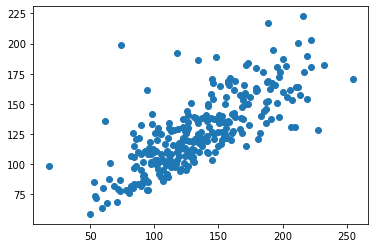

In [125]:
plt.scatter(df.RTV_4dig, df.RTV_tot)
ss.pearsonr(df.RTV_4dig, df.RTV_tot)

(0.8134659903335941, 1.0546470213993068e-44)

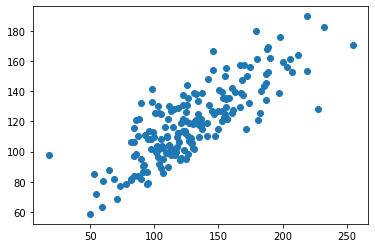

In [126]:
plt.scatter(df_controls.RTV_4dig, df_controls.RTV_tot)
ss.pearsonr(df_controls.RTV_4dig, df_controls.RTV_tot)

In [115]:
prs4 = pd.read_table("/cluster/projects/p33/users/oliviaw/RTV/prs/PRSice_out/RTV_TOP_calcov.best",sep=' ')
prstot = pd.read_table("/cluster/projects/p33/users/oliviaw/RTV/prs/PRSice_out/RTVtot_TOP_calcov.best",sep=' ')

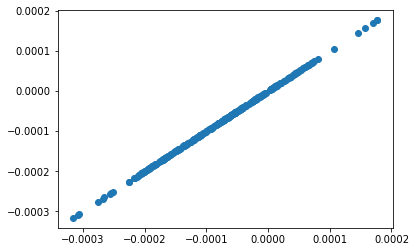

In [116]:
plt.scatter(prs4.PRS, prstot.PRS)

In [117]:
prs4 = prs4.merge(df, on="IID", how="inner")

In [118]:
ss.pearsonr(prs4.PRS, prs4.RTV_4dig)

(0.05848518058999931, 0.32094633788856136)

In [119]:
ss.spearmanr(prs4.PRS, prs4.RTV_4dig)

SpearmanrResult(correlation=0.08093589205825155, pvalue=0.16925799104787104)

In [120]:
print(ss.pearsonr(prs4.PRS, prs4.RTV_4dig))
print(ss.pearsonr(prs4.PRS, prs4.RTV_tot))
print(ss.spearmanr(prs4.PRS, prs4.RTV_4dig))
print(ss.spearmanr(prs4.PRS, prs4.RTV_tot))
ii = (prs4.PRS < 0.0001) & (prs4.PRS > -0.00025) 
print(ss.pearsonr(prs4.PRS[ii], prs4.RTV_4dig[ii]))
print(ss.pearsonr(prs4.PRS[ii], prs4.RTV_tot[ii]))
print(ss.spearmanr(prs4.PRS[ii], prs4.RTV_4dig[ii]))
print(ss.spearmanr(prs4.PRS[ii], prs4.RTV_tot[ii]))

(0.05848518058999931, 0.32094633788856136)
(0.14065436132052228, 0.016537157373549796)
SpearmanrResult(correlation=0.08093589205825155, pvalue=0.16925799104787104)
SpearmanrResult(correlation=0.1526179121404945, pvalue=0.009240363709710007)
(0.1084106743072949, 0.0721480632077936)
(0.19746785784541648, 0.0009729657857542113)
SpearmanrResult(correlation=0.115274040039383, pvalue=0.05577805430542995)
SpearmanrResult(correlation=0.1958904695994635, pvalue=0.001070321812118378)


In [121]:
prs4 = pd.read_table("/cluster/projects/p33/users/oliviaw/RTV/prs/PRSice_out/RTV_TOP_calcov.best",sep=' ')
prs4_controls = prs4.merge(df_controls, on="IID", how="inner")
print(ss.pearsonr(prs4_controls.PRS, prs4_controls.RTV_4dig))
print(ss.pearsonr(prs4_controls.PRS, prs4_controls.RTV_tot))
print(ss.spearmanr(prs4_controls.PRS, prs4_controls.RTV_4dig))
print(ss.spearmanr(prs4_controls.PRS, prs4_controls.RTV_tot))
ii = (prs4_controls.PRS < 0.0001) & (prs4_controls.PRS > -0.00025) 
print(ss.pearsonr(prs4_controls.PRS[ii], prs4_controls.RTV_4dig[ii]))
print(ss.pearsonr(prs4_controls.PRS[ii], prs4_controls.RTV_tot[ii]))
print(ss.spearmanr(prs4_controls.PRS[ii], prs4_controls.RTV_4dig[ii]))
print(ss.spearmanr(prs4_controls.PRS[ii], prs4_controls.RTV_tot[ii]))
print((~ii).sum())

(0.06868967485221683, 0.35551683078392704)
(0.0893711129320215, 0.22893186262729442)
SpearmanrResult(correlation=0.1146953545385477, pvalue=0.12209371970054957)
SpearmanrResult(correlation=0.11401980058430523, pvalue=0.12432301920537445)
(0.18242796498512273, 0.01598321233681736)
(0.18133439590921321, 0.016638005832893883)
SpearmanrResult(correlation=0.19276289188188728, pvalue=0.010823826678289671)
SpearmanrResult(correlation=0.1751336883168655, pvalue=0.02080997143718107)
9


In [105]:
prs4_controls

,FID_x,IID,In_Regression,PRS,FID_y,RTV_4dig_x,RTV_tot_x,FID,RTV_4dig_y,RTV_tot_y
0,FAM001_K50679,FAM001_K50679,Yes,-0.000045,FAM001_K50679,101.788746,103.463473,FAM001_K50679,101.788746,103.463473
1,FAM001_K50703,FAM001_K50703,Yes,-0.000111,FAM001_K50703,152.801858,126.799162,FAM001_K50703,152.801858,126.799162
2,FAM001_K50704,FAM001_K50704,Yes,-0.000120,FAM001_K50704,101.438683,100.225657,FAM001_K50704,101.438683,100.225657
3,FAM001_K50705,FAM001_K50705,Yes,-0.000122,FAM001_K50705,187.001356,133.869787,FAM001_K50705,187.001356,133.869787
4,FAM001_K50706,FAM001_K50706,Yes,-0.000184,FAM001_K50706,156.443600,121.326162,FAM001_K50706,156.443600,121.326162
...,...,...,...,...,...,...,...,...,...,...
182,PACIRHV_K50655,PACIRHV_K50655,Yes,-0.000171,PACIRHV_K50655,107.962337,116.441140,PACIRHV_K50655,107.962337,116.441140
183,PACIRHX_K50647,PACIRHX_K50647,Yes,-0.000052,PACIRHX_K50647,99.831298,109.809021,PACIRHX_K50647,99.831298,109.809021
184,PACIRJN_K50625,PACIRJN_K50625,Yes,-0.000054,PACIRJN_K50625,93.996773,78.474341,PACIRJN_K50625,93.996773,78.474341
185,PACIRLF_K50632,PACIRLF_K50632,Yes,0.000036,PACIRLF_K50632,125.791229,144.123256,PACIRLF_K50632,125.791229,144.123256


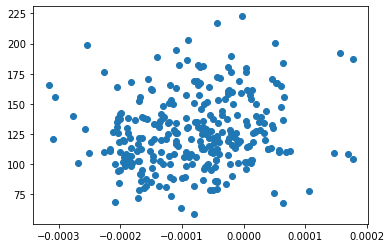

In [41]:
plt.scatter(prs4.PRS, prs4.RTV_tot)

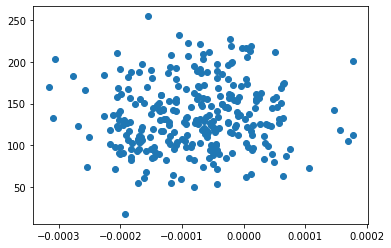

In [42]:
plt.scatter(prs4.PRS, prs4.RTV_4dig)

In [44]:
df

,FID,IID,RTV_4dig,RTV_tot
0,FAM001_U2621,FAM001_U2621,151.215446,164.774678
1,PACIQKH_U677,PACIQKH_U677,191.291037,137.700100
2,FAM001_U1785,FAM001_U1785,130.997226,111.379982
3,FAM001_U1952,FAM001_U1952,107.205072,88.266579
4,FAM001_U240,FAM001_U240,146.252293,120.396630
...,...,...,...,...
287,FAM001_U1674,FAM001_U1674,102.186245,120.066944
288,FAM001_U1933,FAM001_U1933,209.751043,130.675922
289,PACBVJO_BUP85702,PACBVJO_BUP85702,90.807292,101.466577
290,FAM001_U1842,FAM001_U1842,192.211689,194.688152


In [82]:
prs4_controls = prs4.merge(df_controls, on="IID", how="inner")

In [83]:
print(ss.pearsonr(prs4_controls.PRS, prs4_controls.RTV_4dig))
print(ss.pearsonr(prs4_controls.PRS, prs4_controls.RTV_tot))

(0.0875995900932579, 0.2331955821862474)
(0.0992898525285643, 0.17637288955223804)


In [84]:
print(ss.spearmanr(prs4_controls.PRS, prs4_controls.RTV_4dig))
print(ss.spearmanr(prs4_controls.PRS, prs4_controls.RTV_tot))

SpearmanrResult(correlation=0.13474137393149063, pvalue=0.06597413316989485)
SpearmanrResult(correlation=0.12916071775936933, pvalue=0.07810470744479368)


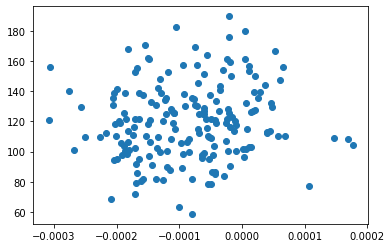

In [87]:
plt.scatter(prs4_controls.PRS, prs4_controls.RTV_tot)

In [65]:
icd_rt = pd.read_table("/cluster/projects/p33/users/oliviaw/RTV/pheno/ISD_RT.txt")
icd_rt.head()

,FID,IID,ISD
0,1000010,1000010,203.221800
1,1000028,1000028,147.725083
2,1000034,1000034,25.435539
3,1000045,1000045,118.370604
4,1000052,1000052,92.635666


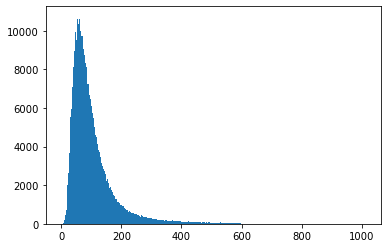

In [68]:
_=plt.hist(icd_rt.ISD, 500)

In [69]:
icd_rt.ISD.describe()

count    490461.000000
mean        102.443730
std          76.689773
min           0.000000
25%          55.262103
50%          80.898496
75%         122.200927
max        1013.013327
Name: ISD, dtype: float64

In [71]:
import scipy.stats as ss

def rint(series, c=3.0/8):
    # c = 3/8 is default in many software packages, it's called Blom ranked-based inverse normal transform
    series_rint = series.copy()
    i_notna = series.notna()
    rank = ss.rankdata(series.loc[i_notna], method="average") # average ordinal
    n = len(rank)
    series_rint.loc[i_notna] = ss.norm.ppf( (rank - c) / (n - 2*c + 1) )
    return series_rint

In [80]:
rtv_4dig = rint(df_controls.RTV_4dig)
rtv_tot = rint(df_controls.RTV_tot)

In [81]:
print(ss.spearmanr(prs4_controls.PRS, rtv_4dig))
print(ss.spearmanr(prs4_controls.PRS, rtv_tot))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 187 and the array at index 1 has size 188

(array([ 3.,  7., 16., 29., 38., 39., 29., 16.,  7.,  3.]),
 array([-2.71260974e+00, -2.17008779e+00, -1.62756584e+00, -1.08504389e+00,
        -5.42521947e-01, -1.77635684e-15,  5.42521947e-01,  1.08504389e+00,
         1.62756584e+00,  2.17008779e+00,  2.71260974e+00]),
 <BarContainer object of 10 artists>)

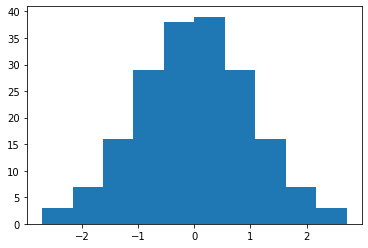

In [75]:
plt.hist(rtv_4dig)

(array([ 1.,  6., 15., 44., 49., 31., 20., 13.,  6.,  2.]),
 array([ 17.34935157,  41.10708322,  64.86481486,  88.6225465 ,
        112.38027815, 136.13800979, 159.89574143, 183.65347308,
        207.41120472, 231.16893636, 254.92666801]),
 <BarContainer object of 10 artists>)

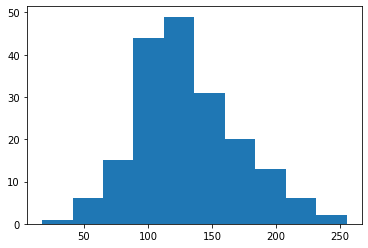

In [76]:
plt.hist(prs4_controls.RTV_4dig)

In [127]:
isd_irnt = pd.read_csv("/cluster/projects/p33/users/alexeas/ukb/pheno/processed/test.irnt.csv")

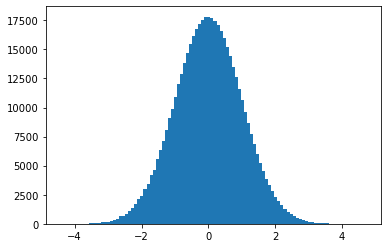

In [131]:
_=plt.hist(isd_irnt.x,100)

In [130]:
isd_irnt.max()

Unnamed: 0    490461.000000
x                  4.704201
dtype: float64

In [132]:

def rint(series, c=3.0/8):
    # c = 3/8 is default in many software packages, it's called Blom ranked-based inverse normal transform
    series_rint = series.copy()
    i_notna = series.notna()
    rank = ss.rankdata(series.loc[i_notna], method="average") # average ordinal
    n = len(rank)
    series_rint.loc[i_notna] = ss.norm.ppf( (rank - c) / (n - 2*c + 1) )
    return series_rint

In [133]:
isd = pd.read_csv("/cluster/projects/p33/users/alexeas/ukb/pheno/processed/ISD.tsv.gz",sep='\t')

In [135]:
isd_irnt_my = rint(isd.ISD)

In [136]:
isd_irnt_my.head()

0    1.393701
1    0.961805
2   -2.059173
3    0.625006
4    0.228848
Name: ISD, dtype: float64

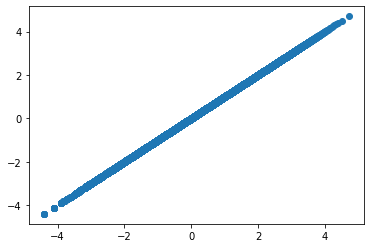

In [139]:
plt.scatter(isd_irnt.x, isd_irnt_my)

In [8]:


@cuda.jit

def f(a, b, c):

    # like threadIdx.x + (blockIdx.x * blockDim.x)

    tid = cuda.grid(1)

    size = len(c)


    if tid < size:

        c[tid] = a[tid] + b[tid]


In [9]:
N = 100000

a = cuda.to_device(np.random.random(N))

b = cuda.to_device(np.random.random(N))

c = cuda.device_array_like(a)

In [11]:
f.forall(len(a))(a, b, c)

print(c.copy_to_host())

[1.44203743 0.65384804 1.57047409 ... 1.30084129 0.99504215 1.61514773]
